In [1]:
# =======
# imports
# =======
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

# Estimating residential electricity demand

The data that we work with are: 
- percentage of population for which WTP > LCOE of at least one available off-grid option
- percentage of population for which WTP > cost of grid expansion in the area where they live
- total population

These three data series are available for each year between 2010 and 2050, from the GIS analysis. 

In [2]:
acc_dir = "C:\\Users\\dallalongaf\\OneDrive - TNO\\work\\2016 02 - TransRisk\\4 - energy access\\AFR_alt_2\\"

gis_dir = acc_dir+"gis_layers\\on-off_analysis\\"
wtp = gpd.read_file(gis_dir+"afretep_etrs_countries_corrected.shp").groupby('COUNTRY').sum()

off_dir = acc_dir+"gis_layers\\off-grid_access\\output\\"
offgrid = pd.read_excel(off_dir+"off-grid_access.xlsx")

data_dir = acc_dir+"code\\input_data\\"
pop_data = pd.read_excel(data_dir+"Population-EstimatesEXCEL.xlsx",sheet_name='Data')

## Import and prepare population data

In [3]:
# get rid of Guinea-Bissau and Western Sahara from on and offgrid DFs:
#offgrid = pd.read_excel(off_dir+"off-grid_access.xlsx")
#ongrid = pd.read_excel(on_dir+"on-grid_access.xlsx")
to_remove = ['Cape Verde','Comoros','Sao Tome and Principe','Guinea-Bissau','Western Sahara']
offgrid = offgrid.drop(offgrid[offgrid.COUNTRY.isin(to_remove)].index, axis=0)\
                 .reset_index().drop('index',axis=1)
offgrid.loc[:,'2010'] = 0

In [4]:
# toal poulation in DF pop:
pop = pop_data[pop_data['Indicator Name']=='Population, total']
pop.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
166,Arab World,ARB,"Population, total",SP.POP.TOTL,9.249093e+07,9.504450e+07,9.768229e+07,1.004111e+08,1.032399e+08,1.061750e+08,...,6.074190e+08,6.152530e+08,6.230380e+08,6.307820e+08,6.384650e+08,6.460880e+08,6.536420e+08,6.611270e+08,6.685250e+08,6.758460e+08
341,Caribbean small states,CSS,"Population, total",SP.POP.TOTL,4.198307e+06,4.277802e+06,4.357746e+06,4.436804e+06,4.513246e+06,4.585777e+06,...,7.628000e+06,7.618000e+06,7.607000e+06,7.590000e+06,7.578000e+06,7.562000e+06,7.543000e+06,7.525000e+06,7.505000e+06,7.482000e+06
516,Central Europe and the Baltics,CEB,"Population, total",SP.POP.TOTL,9.140158e+07,9.223712e+07,9.301489e+07,9.384575e+07,9.472260e+07,9.544706e+07,...,9.205100e+07,9.151700e+07,9.099100e+07,9.047700e+07,8.995900e+07,8.945300e+07,8.894700e+07,8.844000e+07,8.793000e+07,8.740300e+07
691,Early-demographic dividend,EAR,"Population, total",SP.POP.TOTL,9.792269e+08,1.002453e+09,1.026507e+09,1.051326e+09,1.076932e+09,1.103305e+09,...,4.051404e+09,4.076936e+09,4.101645e+09,4.125522e+09,4.148552e+09,4.170717e+09,4.192016e+09,4.212437e+09,4.231978e+09,4.250619e+09
866,East Asia & Pacific,EAS,"Population, total",SP.POP.TOTL,1.042017e+09,1.045308e+09,1.059467e+09,1.084916e+09,1.109997e+09,1.136132e+09,...,2.434665e+09,2.433725e+09,2.432287e+09,2.430332e+09,2.427853e+09,2.424828e+09,2.421272e+09,2.417205e+09,2.412649e+09,2.407261e+09


In [5]:
# Some countries have different names in pop.
# Country names in ongrid and offgrid are leading. 
# Put the names that change in a list called replacements:
replacements = []
for c in offgrid.COUNTRY:
    inout = c in list(pop['Country Name'])
    # if name is not found in pop...
    if not inout:
        print('---')
        print(c)
        replacements.append(c) # ...put it in replacements
        # then check if any parts of the name are present 
        # anywhere-else in pop and print an overview
        for x in c.split(' '):
            for name in pop[pop['Country Name'].str.contains(x)].loc[:,'Country Name'].values:
                print(c,"-->", name)


---
Congo
Congo --> Congo, Dem. Rep.
Congo --> Congo, Rep.
---
Democratic Republic of Congo
Democratic Republic of Congo --> Central African Republic
Democratic Republic of Congo --> Czech Republic
Democratic Republic of Congo --> Dominican Republic
Democratic Republic of Congo --> Kyrgyz Republic
Democratic Republic of Congo --> Slovak Republic
Democratic Republic of Congo --> Syrian Arab Republic
Democratic Republic of Congo --> Isle of Man
Democratic Republic of Congo --> Congo, Dem. Rep.
Democratic Republic of Congo --> Congo, Rep.
---
Egypt
Egypt --> Egypt, Arab Rep.
---
Gambia
Gambia --> Gambia, The
---
Guinea Bissau
Guinea Bissau --> Equatorial Guinea
Guinea Bissau --> Guinea
Guinea Bissau --> Guinea-Bissau
Guinea Bissau --> Papua New Guinea
Guinea Bissau --> Guinea-Bissau
---
Ivory Coast


In [6]:
# Ivory Coast is not picked up by our algorithm. 
# It is actually stored in pop with its French name:
pop[pop['Country Name'].str.contains('Ivo')].loc[:,'Country Name'].values

array(["Cote d'Ivoire"], dtype=object)

In [7]:
replacements

['Congo',
 'Democratic Republic of Congo',
 'Egypt',
 'Gambia',
 'Guinea Bissau',
 'Ivory Coast']

In [8]:
# In pop replace the wrong names with the right ones
to_replace = ['Congo, Rep.','Congo, Dem. Rep.',
              'Egypt, Arab Rep.','Gambia, The','Guinea-Bissau',
              "Cote d'Ivoire"]
pop = pop.replace(to_replace,replacements)
pop[pop['Country Name'].isin(replacements)]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
15216,Democratic Republic of Congo,COD,"Population, total",SP.POP.TOTL,15248251.0,15637733.0,16041263.0,16461930.0,16903923.0,17369883.0,...,161023000.0,164964000.0,168936000.0,172935000.0,176961000.0,181010000.0,185080000.0,189170000.0,193278000.0,197404000.0
15391,Congo,COG,"Population, total",SP.POP.TOTL,1037220.0,1064111.0,1092292.0,1121735.0,1152412.0,1184316.0,...,9521000.0,9736000.0,9952000.0,10170000.0,10389000.0,10610000.0,10832000.0,11056000.0,11282000.0,11510000.0
15741,Ivory Coast,CIV,"Population, total",SP.POP.TOTL,3558988.0,3694205.0,3841071.0,3996941.0,4157965.0,4321791.0,...,42708000.0,43631000.0,44565000.0,45509000.0,46464000.0,47428000.0,48402000.0,49385000.0,50376000.0,51375000.0
17666,Egypt,EGY,"Population, total",SP.POP.TOTL,26996533.0,27744712.0,28506176.0,29281250.0,30071102.0,30875964.0,...,138806000.0,140530000.0,142235000.0,143918000.0,145576000.0,147206000.0,148807000.0,150379000.0,151921000.0,153433000.0
19766,Gambia,GMB,"Population, total",SP.POP.TOTL,367928.0,376737.0,383523.0,389072.0,394553.0,400861.0,...,3856000.0,3936000.0,4015000.0,4094000.0,4173000.0,4251000.0,4329000.0,4407000.0,4485000.0,4562000.0
21691,Guinea Bissau,GNB,"Population, total",SP.POP.TOTL,616409.0,623415.0,629969.0,636586.0,643961.0,652562.0,...,3088000.0,3144000.0,3201000.0,3258000.0,3316000.0,3373000.0,3431000.0,3488000.0,3545000.0,3603000.0


In [9]:
# Double-check that it worked
for c in offgrid.index:
    inout = c in list(pop['Country Name'])
    if not inout:
        print(c)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [10]:
#pop = original_pop
pop.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
166,Arab World,ARB,"Population, total",SP.POP.TOTL,9.249093e+07,9.504450e+07,9.768229e+07,1.004111e+08,1.032399e+08,1.061750e+08,...,6.074190e+08,6.152530e+08,6.230380e+08,6.307820e+08,6.384650e+08,6.460880e+08,6.536420e+08,6.611270e+08,6.685250e+08,6.758460e+08
341,Caribbean small states,CSS,"Population, total",SP.POP.TOTL,4.198307e+06,4.277802e+06,4.357746e+06,4.436804e+06,4.513246e+06,4.585777e+06,...,7.628000e+06,7.618000e+06,7.607000e+06,7.590000e+06,7.578000e+06,7.562000e+06,7.543000e+06,7.525000e+06,7.505000e+06,7.482000e+06
516,Central Europe and the Baltics,CEB,"Population, total",SP.POP.TOTL,9.140158e+07,9.223712e+07,9.301489e+07,9.384575e+07,9.472260e+07,9.544706e+07,...,9.205100e+07,9.151700e+07,9.099100e+07,9.047700e+07,8.995900e+07,8.945300e+07,8.894700e+07,8.844000e+07,8.793000e+07,8.740300e+07
691,Early-demographic dividend,EAR,"Population, total",SP.POP.TOTL,9.792269e+08,1.002453e+09,1.026507e+09,1.051326e+09,1.076932e+09,1.103305e+09,...,4.051404e+09,4.076936e+09,4.101645e+09,4.125522e+09,4.148552e+09,4.170717e+09,4.192016e+09,4.212437e+09,4.231978e+09,4.250619e+09
866,East Asia & Pacific,EAS,"Population, total",SP.POP.TOTL,1.042017e+09,1.045308e+09,1.059467e+09,1.084916e+09,1.109997e+09,1.136132e+09,...,2.434665e+09,2.433725e+09,2.432287e+09,2.430332e+09,2.427853e+09,2.424828e+09,2.421272e+09,2.417205e+09,2.412649e+09,2.407261e+09


In [11]:
original_pop = pop
# Let's give pop the same structure as offgrid and ongrid
cols = ['Country Name','2010','2020','2030','2040','2050']
pop = pop[cols]
pop = pop.sort_values(by='Country Name')
# Let's only select relevant countries
pop = pop[pop['Country Name'].isin(wtp.index)]
pop.columns = ['COUNTRY','2010','2020','2030','2040','2050']
#pop = pop.set_index('COUNTRY')
pop

,COUNTRY,2010,2020,2030,2040,2050
7866,Algeria,3.611764e+07,43333000.0,48822000.0,53249000.0,57437000.0
8391,Angola,2.336913e+07,32827000.0,44712000.0,59249000.0,76046000.0
11016,Benin,9.199259e+06,12123000.0,15628000.0,19614000.0,23930000.0
11891,Botswana,2.014866e+06,2416000.0,2800000.0,3138000.0,3421000.0
12766,Burkina Faso,1.560522e+07,20903000.0,27382000.0,34954000.0,43207000.0
12941,Burundi,8.766930e+06,11939000.0,15799000.0,20377000.0,25762000.0
13466,Cameroon,1.997050e+07,25958000.0,32980000.0,41021000.0,49817000.0
13991,Central African Republic,4.448525e+06,4921000.0,6124000.0,7481000.0,8851000.0
14166,Chad,1.188720e+07,16285000.0,21460000.0,27321000.0,33636000.0
15041,Comoros,6.896920e+05,870000.0,1062000.0,1262000.0,1463000.0


In [12]:
# There's no projection for Eritrea. We estimate it using 
# the average growth rate per decade of its neighbors 
pop = pop.set_index('COUNTRY')
neighbors = ['Sudan','Djibouti','Ethiopia','Somalia']
for y in pop.columns[1:]:
    pop.loc['Eritrea',y] = pop.loc['Eritrea','%s'%(int(y)-10)] *\
                               (1+((pop.loc[neighbors,y] - pop.loc[neighbors,'%s'%(int(y)-10)]) /\
                                 pop.loc[neighbors,'%s'%(int(y)-10)]).mean())
pop

,2010,2020,2030,2040,2050
COUNTRY,,,,,
Algeria,3.611764e+07,4.333300e+07,4.882200e+07,5.324900e+07,5.743700e+07
Angola,2.336913e+07,3.282700e+07,4.471200e+07,5.924900e+07,7.604600e+07
Benin,9.199259e+06,1.212300e+07,1.562800e+07,1.961400e+07,2.393000e+07
Botswana,2.014866e+06,2.416000e+06,2.800000e+06,3.138000e+06,3.421000e+06
Burkina Faso,1.560522e+07,2.090300e+07,2.738200e+07,3.495400e+07,4.320700e+07
Burundi,8.766930e+06,1.193900e+07,1.579900e+07,2.037700e+07,2.576200e+07
Cameroon,1.997050e+07,2.595800e+07,3.298000e+07,4.102100e+07,4.981700e+07
Central African Republic,4.448525e+06,4.921000e+06,6.124000e+06,7.481000e+06,8.851000e+06
Chad,1.188720e+07,1.628500e+07,2.146000e+07,2.732100e+07,3.363600e+07


## Calculate on- and off-grid potentials
Expressed as number of people that can gain access to the grid, off-grid solutions or both. 

In [13]:
# Import wtp data table, aggregated by country 
wtp = gpd.read_file(gis_dir+"afretep_etrs_countries_corrected.shp").groupby('COUNTRY').sum()
wtp.head()

,wtp2020,wtp2030,wtp2040,wtp2050,tot_pop
COUNTRY,,,,,
Algeria,2.493864e+07,2.500388e+07,2.505002e+07,2.505002e+07,2.505002e+07
Angola,1.429439e+07,1.552171e+07,1.552171e+07,1.552186e+07,1.552295e+07
Benin,1.296170e+06,8.043852e+06,8.054508e+06,8.054520e+06,8.054520e+06
Botswana,0.000000e+00,0.000000e+00,1.333993e+06,1.336533e+06,1.336563e+06
Burkina Faso,2.920000e+02,2.920000e+02,2.920000e+02,6.730000e+02,1.290668e+07


In [14]:
# The wtp[year] columns contain the number of people that have offgrid access.
# let's normalize them with the total pop:
wtp.loc[:,'wtp2020_frac'] = wtp.loc[:,'wtp2020'] / wtp.loc[:,'tot_pop']
wtp.loc[:,'wtp2030_frac'] = wtp.loc[:,'wtp2030'] / wtp.loc[:,'tot_pop']
wtp.loc[:,'wtp2040_frac'] = wtp.loc[:,'wtp2040'] / wtp.loc[:,'tot_pop']
wtp.loc[:,'wtp2050_frac'] = wtp.loc[:,'wtp2050'] / wtp.loc[:,'tot_pop']
wtp.head()

,wtp2020,wtp2030,wtp2040,wtp2050,tot_pop,wtp2020_frac,wtp2030_frac,wtp2040_frac,wtp2050_frac
COUNTRY,,,,,,,,,
Algeria,2.493864e+07,2.500388e+07,2.505002e+07,2.505002e+07,2.505002e+07,0.995554,0.998158,1.000000,1.000000
Angola,1.429439e+07,1.552171e+07,1.552171e+07,1.552186e+07,1.552295e+07,0.920855,0.999920,0.999920,0.999929
Benin,1.296170e+06,8.043852e+06,8.054508e+06,8.054520e+06,8.054520e+06,0.160925,0.998676,0.999999,1.000000
Botswana,0.000000e+00,0.000000e+00,1.333993e+06,1.336533e+06,1.336563e+06,0.000000,0.000000,0.998077,0.999978
Burkina Faso,2.920000e+02,2.920000e+02,2.920000e+02,6.730000e+02,1.290668e+07,0.000023,0.000023,0.000023,0.000052


In [15]:
# import clean buffer tables
years = ['2010','2020','2030','2040','2050']
buff_dir = gis_dir+"buffers_clean\\"
buffers = []
for y in years:
    b_name = 'buffer_%s_clean.shp'%y
    b = gpd.read_file(buff_dir+b_name)
    buffers.append(b.groupby('COUNTRY').sum())#.reset_index())

buffers[4].head()

,2050,buff_wtp,buff_pop,buff_grid
COUNTRY,,,,
Algeria,55877.862595,374606.0,374606.0,0.0
Angola,131994.910941,1047298.0,1047298.0,0.0
Benin,53162.849873,252340.0,252342.0,2.0
Burkina Faso,9914.758270,49.0,738004.0,737955.0
Burundi,10124.681934,0.0,172712.0,172712.0


There are 4 columns in each of these tables: 
- [year] contains the buffer distance (in m) for that particular country and year combination;
- buff_wtp contains the number of people that fall within the buffer AND have off-grid access (WTP > LCOE);
- buff_pop contains the total number of people in the buffer;
- buff_grid contains the number of people in the buffer that DO NOT have off-grid access (but DO have grid access, because they are in the buffer)

The 2010 table is an exception. In this year we assume only grid access for the people in the buffer:

In [16]:
buffers[0].loc[:,'buff_wtp'] = 0.
buffers[0].head()

,2010,buff_pop,buff_wtp
COUNTRY,,,
Algeria,20000.0,20419740.0,0.0
Angola,18000.0,4536770.0,0.0
Benin,1000.0,2379046.0,0.0
Botswana,2000.0,567460.0,0.0
Burkina Faso,500.0,1322271.0,0.0


In [17]:
# get rid of Guinea-Bissau and Western Sahara from all these DFs:
to_remove = ['Cape Verde','Comoros','Sao Tome and Principe','Guinea-Bissau','Western Sahara']
for df in buffers:
    df = df.reset_index()
    df = df.drop(df[df.COUNTRY.isin(to_remove)].index, axis=0)\
           .reset_index().drop('index',axis=1).set_index('COUNTRY')

wtp = wtp.reset_index()
wtp = wtp.drop(wtp[wtp.COUNTRY.isin(to_remove)].index, axis=0)\
         .reset_index().drop('index',axis=1).set_index('COUNTRY')

In [18]:
buffers[0]

,2010,buff_pop,buff_wtp
COUNTRY,,,
Algeria,20000.0,20419740.0,0.0
Angola,18000.0,4536770.0,0.0
Benin,1000.0,2379046.0,0.0
Botswana,2000.0,567460.0,0.0
Burkina Faso,500.0,1322271.0,0.0
Burundi,3000.0,240607.0,0.0
Cameroon,3000.0,8068971.0,0.0
Central African Republic,3000.0,306447.0,0.0
Chad,5000.0,628358.0,0.0


In [19]:
# We normalize all columns in buffer tables with total pop from countries table
# first 2010:
buffers[0].loc[:,'buff_pop_frac'] = buffers[0].loc[:,'buff_pop'] / wtp.loc[:,'tot_pop']
buffers[0].loc[:,'buff_wtp_frac'] = buffers[0].loc[:,'buff_wtp'] / wtp.loc[:,'tot_pop']
# then the others
for b in buffers[1:]:
    b.loc[:,'buff_wtp_frac'] = b.loc[:,'buff_wtp'] / wtp.loc[:,'tot_pop']
    b.loc[:,'buff_pop_frac'] = b.loc[:,'buff_pop'] / wtp.loc[:,'tot_pop']
    b.loc[:,'buff_grid_frac'] = b.loc[:,'buff_grid'] / wtp.loc[:,'tot_pop']
buffers[3].head()

,2040,buff_wtp,buff_pop,buff_grid,buff_wtp_frac,buff_pop_frac,buff_grid_frac
COUNTRY,,,,,,,
Algeria,45699.745547,600434.0,600434.0,0.0,0.023969,0.023969,0.000000
Angola,97898.218830,1523916.0,1524024.0,108.0,0.098172,0.098179,0.000007
Benin,38150.127226,461265.0,461265.0,0.0,0.057268,0.057268,0.000000
Botswana,18030.534351,93199.0,93249.0,50.0,0.069730,0.069768,0.000037
Burkina Faso,7115.776081,43.0,640636.0,640593.0,0.000003,0.049636,0.049633


Now for each year we want to count the fraction of people that:
- only can access the grid --> buff_grid_frac
- can access both --> buff_wtp_frac
- olny have offgrid access --> wtp[year]_frac

Let's put them into one single DF:

In [20]:
# 2010: 
# -----
# 2010 grid only = 2010 buff_pop_frac
potentials = buffers[0][['buff_pop_frac']]
potentials.columns = ['grid_2010']
# 2010 overlap = 0
potentials.loc[:,'overlap_2010'] = 0.
# 2010 off-grid = 0
potentials.loc[:,'offgrid_2010'] = 0.
# 2010 total
potentials.loc[:,'total_2010'] = potentials.loc[:,'grid_2010'] + potentials.loc[:,'overlap_2010']\
                                                               + potentials.loc[:,'offgrid_2010']

# 2020: 
# ----- 
# 2020 grid only = 2010 grid + 2020 buff_grid_frac
potentials.loc[:,'grid_2020'] = potentials.loc[:,'grid_2010'] + buffers[1].loc[:,'buff_grid_frac']
# 2020 overlap = 2010 overlap + 2020 buff_wtp_frac
potentials.loc[:,'overlap_2020'] = potentials.loc[:,'overlap_2010'] + buffers[1].loc[:,'buff_wtp_frac']
# 2020 off-grid = 2020 wtp2020_frac - 2010 buff_wtp_frac - 2020 overlap
potentials.loc[:,'offgrid_2020'] = wtp.loc[:,'wtp2020_frac'] - potentials.loc[:,'grid_2020']\
                                                             - potentials.loc[:,'overlap_2020']
# in case it's negative put it to zero
potentials.loc[potentials['offgrid_2020']<0,'offgrid_2020'] = 0.
# 2020 total
potentials.loc[:,'total_2020'] = potentials.loc[:,'grid_2020'] + potentials.loc[:,'overlap_2020']\
                                                               + potentials.loc[:,'offgrid_2020']
# generalize to other years
for i in range(2,5):
    #print(i)
    y = years[i]
    ym10 = years[i-1]
    b = buffers[i]
    # grid
    potentials.loc[:,'grid_%s'%y] = potentials.loc[:,'grid_%s'%ym10] + b.loc[:,'buff_grid_frac']
    # overlap = [y-10] overlap + [y] buff_wtp_frac
    potentials.loc[:,'overlap_%s'%y] = potentials.loc[:,'overlap_%s'%ym10] + b.loc[:,'buff_wtp_frac']
    # off-grid = [y] wtp[y]_frac - [y-10] buff_wtp_frac - [y-10] overlap
    potentials.loc[:,'offgrid_%s'%y] = wtp.loc[:,'wtp%s_frac'%y] - potentials.loc[:,'grid_%s'%y]\
                                                                 - potentials.loc[:,'overlap_%s'%y]
    # in case it's negative put it to zero
    potentials.loc[potentials['offgrid_%s'%y]<0,'offgrid_%s'%y] = 0.
    # total
    potentials.loc[:,'total_%s'%y] = potentials.loc[:,'grid_%s'%y] + potentials.loc[:,'overlap_%s'%y]\
                                                                   + potentials.loc[:,'offgrid_%s'%y]

#for c in potentials.columns:
#    if 'total' in c:
#        print(c)
#        print(potentials[potentials[c] > 1])
#        print("\n")

potentials #.head()

C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\CepPy3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\CepPy3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,grid_2010,overlap_2010,offgrid_2010,total_2010,grid_2020,overlap_2020,offgrid_2020,total_2020,grid_2030,overlap_2030,offgrid_2030,total_2030,grid_2040,overlap_2040,offgrid_2040,total_2040,grid_2050,overlap_2050,offgrid_2050,total_2050
COUNTRY,,,,,,,,,,,,,,,,,,,,
Algeria,0.815159,0.0,0.0,0.815159,0.815314,0.042142,0.138097,0.995554,0.815350,8.092213e-02,0.101886,0.998158,0.815350,1.048915e-01,0.079758,1.000000,0.815350,1.198458e-01,0.064804,1.000000
Angola,0.292262,0.0,0.0,0.292262,0.294373,0.083310,0.543172,0.920855,0.294376,1.906292e-01,0.514914,0.999920,0.294383,2.888010e-01,0.416736,0.999920,0.294383,3.562687e-01,0.349278,0.999929
Benin,0.295368,0.0,0.0,0.295368,0.719071,0.052563,0.000000,0.771634,0.719090,1.637558e-01,0.115830,0.998676,0.719090,2.210236e-01,0.059885,0.999999,0.719090,2.523526e-01,0.028558,1.000000
Botswana,0.424567,0.0,0.0,0.424567,0.708500,0.000000,0.000000,0.708500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Burkina Faso,0.102449,0.0,0.0,0.102449,0.311239,0.000004,0.000000,0.311243,0.393712,3.641526e-06,0.000000,0.393716,0.443345,6.973134e-06,0.000000,0.443352,0.500521,1.076962e-05,0.000000,0.500532
Burundi,0.032992,0.0,0.0,0.032992,0.051962,0.000000,0.000000,0.051962,0.073107,0.000000e+00,0.000000,0.073107,0.102902,0.000000e+00,0.000000,0.102902,0.126584,0.000000e+00,0.000000,0.126584
Cameroon,0.469599,0.0,0.0,0.469599,0.659340,0.000002,0.000000,0.659342,0.681593,1.085400e-01,0.019967,0.810100,0.681608,1.910212e-01,0.127209,0.999838,0.681624,2.334961e-01,0.084718,0.999838
Central African Republic,0.089681,0.0,0.0,0.089681,0.116694,0.000000,0.000000,0.116694,0.151964,0.000000e+00,0.000000,0.151964,0.192301,0.000000e+00,0.000000,0.192301,0.215020,0.000000e+00,0.000000,0.215020
Chad,0.067118,0.0,0.0,0.067118,0.086557,0.000000,0.000000,0.086557,0.106120,5.340708e-07,0.000000,0.106120,0.124511,2.627629e-05,0.000000,0.124537,0.129173,2.627629e-05,0.000000,0.129199


In [21]:
for c in potentials.columns:
    if 'total' in c:
        print(c)
        print(potentials[potentials[c] > 1])
        print("\n")


total_2010
Empty DataFrame
Columns: [grid_2010, overlap_2010, offgrid_2010, total_2010, grid_2020, overlap_2020, offgrid_2020, total_2020, grid_2030, overlap_2030, offgrid_2030, total_2030, grid_2040, overlap_2040, offgrid_2040, total_2040, grid_2050, overlap_2050, offgrid_2050, total_2050]
Index: []


total_2020
Empty DataFrame
Columns: [grid_2010, overlap_2010, offgrid_2010, total_2010, grid_2020, overlap_2020, offgrid_2020, total_2020, grid_2030, overlap_2030, offgrid_2030, total_2030, grid_2040, overlap_2040, offgrid_2040, total_2040, grid_2050, overlap_2050, offgrid_2050, total_2050]
Index: []


total_2030
Empty DataFrame
Columns: [grid_2010, overlap_2010, offgrid_2010, total_2010, grid_2020, overlap_2020, offgrid_2020, total_2020, grid_2030, overlap_2030, offgrid_2030, total_2030, grid_2040, overlap_2040, offgrid_2040, total_2040, grid_2050, overlap_2050, offgrid_2050, total_2050]
Index: []


total_2040
Empty DataFrame
Columns: [grid_2010, overlap_2010, offgrid_2010, total_2010, 

In [22]:
# get rid of West Sahara (why is it still there?!?)
potentials = potentials.drop('Western Sahara')
# extrapolate NaNs for Botswana

for i in range(2,5):
    #print(i)
    y = years[i]
    ym10 = years[i-1]
    c = 'Botswana'
    # grid
    potentials.loc[c,'grid_%s'%y] = potentials.loc[c,'grid_%s'%ym10]
    # overlap 
    potentials.loc[c,'overlap_%s'%y] = potentials.loc[c,'overlap_%s'%ym10]
    # off-grid
    potentials.loc[c,'offgrid_%s'%y] = potentials.loc[c,'offgrid_%s'%ym10] 
    # total
    potentials.loc[c,'total_%s'%y] = potentials.loc[c,'total_%s'%ym10]
    
potentials

,grid_2010,overlap_2010,offgrid_2010,total_2010,grid_2020,overlap_2020,offgrid_2020,total_2020,grid_2030,overlap_2030,offgrid_2030,total_2030,grid_2040,overlap_2040,offgrid_2040,total_2040,grid_2050,overlap_2050,offgrid_2050,total_2050
COUNTRY,,,,,,,,,,,,,,,,,,,,
Algeria,0.815159,0.0,0.0,0.815159,0.815314,0.042142,0.138097,0.995554,0.815350,8.092213e-02,0.101886,0.998158,0.815350,1.048915e-01,0.079758,1.000000,0.815350,1.198458e-01,0.064804,1.000000
Angola,0.292262,0.0,0.0,0.292262,0.294373,0.083310,0.543172,0.920855,0.294376,1.906292e-01,0.514914,0.999920,0.294383,2.888010e-01,0.416736,0.999920,0.294383,3.562687e-01,0.349278,0.999929
Benin,0.295368,0.0,0.0,0.295368,0.719071,0.052563,0.000000,0.771634,0.719090,1.637558e-01,0.115830,0.998676,0.719090,2.210236e-01,0.059885,0.999999,0.719090,2.523526e-01,0.028558,1.000000
Botswana,0.424567,0.0,0.0,0.424567,0.708500,0.000000,0.000000,0.708500,0.708500,0.000000e+00,0.000000,0.708500,0.708500,0.000000e+00,0.000000,0.708500,0.708500,0.000000e+00,0.000000,0.708500
Burkina Faso,0.102449,0.0,0.0,0.102449,0.311239,0.000004,0.000000,0.311243,0.393712,3.641526e-06,0.000000,0.393716,0.443345,6.973134e-06,0.000000,0.443352,0.500521,1.076962e-05,0.000000,0.500532
Burundi,0.032992,0.0,0.0,0.032992,0.051962,0.000000,0.000000,0.051962,0.073107,0.000000e+00,0.000000,0.073107,0.102902,0.000000e+00,0.000000,0.102902,0.126584,0.000000e+00,0.000000,0.126584
Cameroon,0.469599,0.0,0.0,0.469599,0.659340,0.000002,0.000000,0.659342,0.681593,1.085400e-01,0.019967,0.810100,0.681608,1.910212e-01,0.127209,0.999838,0.681624,2.334961e-01,0.084718,0.999838
Central African Republic,0.089681,0.0,0.0,0.089681,0.116694,0.000000,0.000000,0.116694,0.151964,0.000000e+00,0.000000,0.151964,0.192301,0.000000e+00,0.000000,0.192301,0.215020,0.000000e+00,0.000000,0.215020
Chad,0.067118,0.0,0.0,0.067118,0.086557,0.000000,0.000000,0.086557,0.106120,5.340708e-07,0.000000,0.106120,0.124511,2.627629e-05,0.000000,0.124537,0.129173,2.627629e-05,0.000000,0.129199


In [23]:
# split it up
ongrid = potentials.loc[:,[c for c in potentials.columns if ('grid' in c and 'off' not in c)]]
ongrid.columns = years
ongrid.head()

,2010,2020,2030,2040,2050
COUNTRY,,,,,
Algeria,0.815159,0.815314,0.815350,0.815350,0.815350
Angola,0.292262,0.294373,0.294376,0.294383,0.294383
Benin,0.295368,0.719071,0.719090,0.719090,0.719090
Botswana,0.424567,0.708500,0.708500,0.708500,0.708500
Burkina Faso,0.102449,0.311239,0.393712,0.443345,0.500521


In [24]:
offgrid = potentials.loc[:,[c for c in potentials.columns if 'offgrid' in c]]
offgrid.columns = years
offgrid.head()

,2010,2020,2030,2040,2050
COUNTRY,,,,,
Algeria,0.0,0.138097,0.101886,0.079758,0.064804
Angola,0.0,0.543172,0.514914,0.416736,0.349278
Benin,0.0,0.000000,0.115830,0.059885,0.028558
Botswana,0.0,0.000000,0.000000,0.000000,0.000000
Burkina Faso,0.0,0.000000,0.000000,0.000000,0.000000


In [25]:
overlap = potentials.loc[:,[c for c in potentials.columns if 'overlap' in c]]
overlap.columns = years
overlap.head()

,2010,2020,2030,2040,2050
COUNTRY,,,,,
Algeria,0.0,0.042142,0.080922,0.104892,0.119846
Angola,0.0,0.083310,0.190629,0.288801,0.356269
Benin,0.0,0.052563,0.163756,0.221024,0.252353
Botswana,0.0,0.000000,0.000000,0.000000,0.000000
Burkina Faso,0.0,0.000004,0.000004,0.000007,0.000011


In [26]:
# conver to mil people
pop = pop.drop(['Comoros','Sao Tome and Principe'])
on_pop_mil = ongrid * pop / 1000000.
on_pop = on_pop_mil * 1000000.
off_pop_mil = offgrid * pop / 1000000.
off_pop = off_pop_mil * 1000000.
overlap_pop_mil = overlap * pop / 1000000.
overlap_pop = overlap_pop_mil *  1000000.
pop_mil = pop / 1000000.

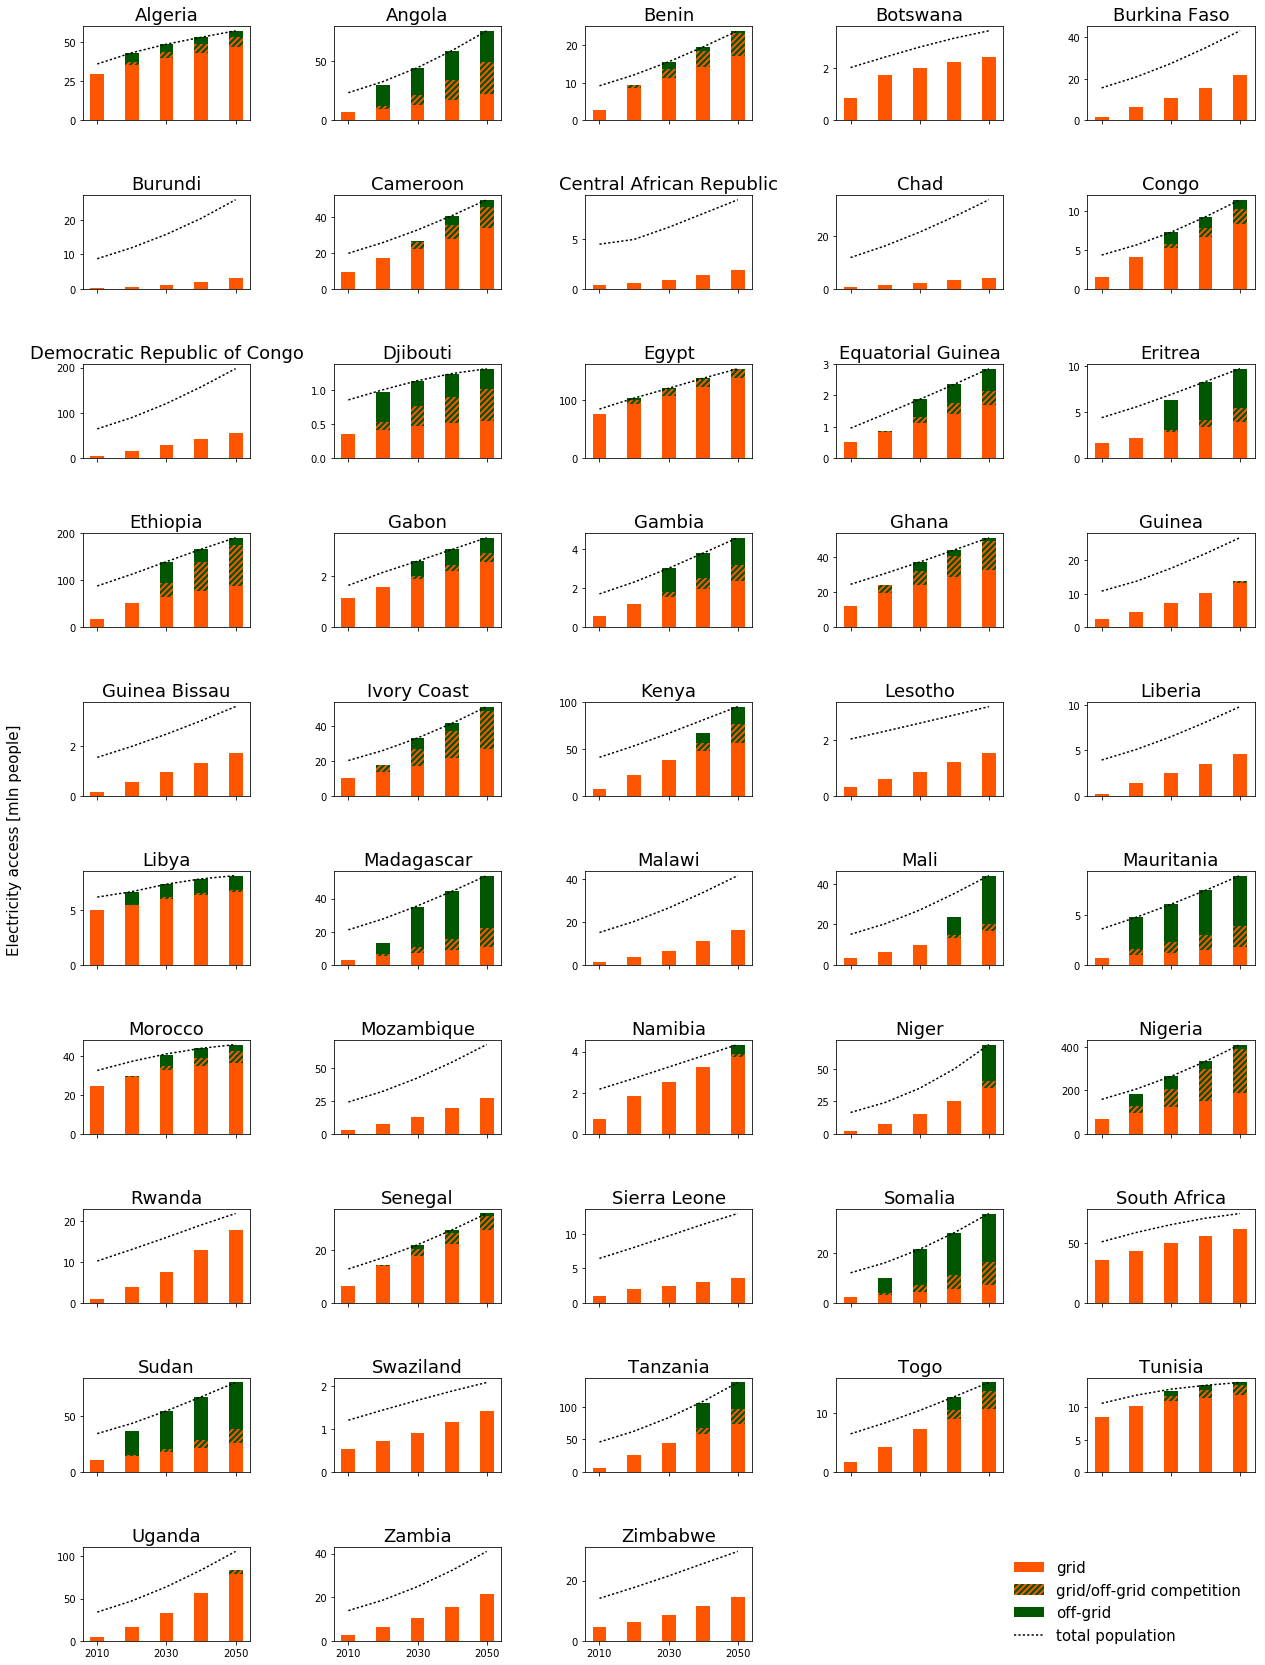

In [27]:
# Make a matrix of plots
rows = 10
cols = 5
fig, ax = plt.subplots(rows, cols, sharex='col') #, sharey='row')
fig.set_size_inches(21,29.7)
fig.subplots_adjust(hspace=0.8, wspace=0.5)

import matplotlib as mpl
bar_w = 4
orange = (254/255.,85/255.,0)
green = (0,85/255.,0)
mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = orange
mpl.rcParams['font.size'] = 15
for i in range(rows):
    for j in range(cols):
        idx = cols*i + j
        if idx < len(on_pop_mil):
            on_line = ax[i,j].bar(on_pop_mil.columns.astype(float),\
                                  on_pop_mil.iloc[idx,:],\
                                  bar_w,color=orange)
            
            overlap_line = ax[i,j].bar(on_pop_mil.columns.astype(float),\
                                       overlap_pop_mil.iloc[idx,:],\
                                       bar_w, color=green,hatch='////',\
                                       bottom = (on_pop_mil.iloc[idx,:]))
            
            off_line = ax[i,j].bar(on_pop_mil.columns.astype(float),\
                                   off_pop_mil.iloc[idx,:],\
                                   bar_w, color=green,\
                                   bottom = on_pop_mil.iloc[idx,:] + overlap_pop_mil.iloc[idx,:])
            
            pop_line, = ax[i,j].plot(pop_mil.iloc[idx,:].transpose(),':',color='black')
            
            
            ax[i,j].set_title(on_pop_mil.index[idx])
            ax[i,j].set_xticks([2010,2030,2050])
        elif idx == len(on_pop_mil):
            ax[i,j].axis('off')
            plt.legend([on_line,overlap_line,off_line,pop_line],
                       ['grid','grid/off-grid competition','off-grid','total population'], 
                       frameon = False)
        else:
            ax[i,j].axis('off')
            
# overall axes titles as text objects
fig.text(0.08, 0.5, 'Electricity access [mln people]', ha='center', va='center', rotation='vertical')

In [28]:
#fig.savefig('access_potential.jpg',dpi=350)

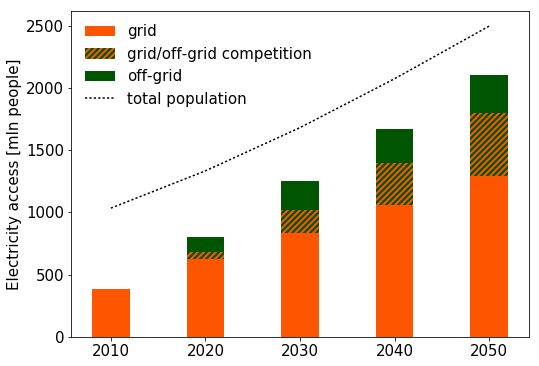

In [29]:
# And for the whole of Africa
fig, ax = plt.subplots()
fig.set_size_inches(8.2,6)
on_line = ax.bar(on_pop_mil.columns.astype(float),\
                 on_pop_mil.sum(),\
                 bar_w,color=orange)
            
overlap_line = ax.bar(on_pop_mil.columns.astype(float),\
                      overlap_pop_mil.sum(),\
                      bar_w, color=green,hatch='////',\
                      bottom = (on_pop_mil.sum()))
            
off_line = ax.bar(on_pop_mil.columns.astype(float),\
                 off_pop_mil.sum(),\
                 bar_w, color=green,\
                 bottom = on_pop_mil.sum() + overlap_pop_mil.sum())
            
pop_line, = ax.plot(pop_mil.sum().transpose(),':',color='black')
            

#ax.set_title("Africa")
#ax.set_xticks([2010,2030,2050])
plt.legend([on_line,overlap_line,off_line,pop_line],
           ['grid','grid/off-grid competition','off-grid','total population'], 
           frameon = False)
 
# overall title and y-axis label
#fig.suptitle('Potential for electricity access in Africa')            
ax.set_ylabel('Electricity access [mln people]')

In [30]:
#fig.savefig('access_potential_afr.jpg',dpi=250)

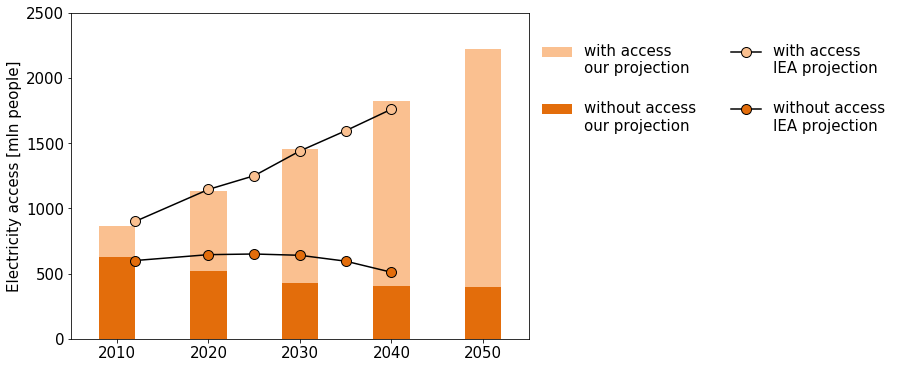

In [31]:
import textwrap as tw

# overall summary for SSA to compare with IEA prj
# North Africa
NAC = ['Morocco','Algeria','Tunisia','Libya','Egypt']
# Sub-Saharan Africa
SSA = [c for c in pop.index if c not in NAC]

# bar colors
IEA_acc_color = (250/255.,192/255.,144/255.)
IEA_noacc_color = (227/255.,109/255.,11/255.)

# IEA prjs
x_IEA = np.array([2012,2020,2025,2030,2035,2040])
acc_IEA = np.array([300,500,600,800,1000,1250])
no_acc_IEA = np.array([600,645,650,640,595,510])

# plot
fig, ax = plt.subplots()
fig.set_size_inches(8.2,6)

no_acc_line = ax.bar(on_pop_mil.columns.astype(float),\
                     pop_mil.loc[SSA,:].sum() -\
                     (on_pop_mil.loc[SSA,:].sum() + off_pop_mil.loc[SSA,:].sum() + overlap_pop_mil.loc[SSA,:].sum()),\
                     bar_w,color=IEA_noacc_color)

acc_line = ax.bar(on_pop_mil.columns.astype(float),\
                  on_pop_mil.loc[SSA,:].sum() + off_pop_mil.loc[SSA,:].sum() + overlap_pop_mil.loc[SSA,:].sum(),\
                  bar_w,color=IEA_acc_color,\
                  bottom = pop_mil.loc[SSA,:].sum() -\
                           (on_pop_mil.loc[SSA,:].sum() + off_pop_mil.loc[SSA,:].sum() + overlap_pop_mil.loc[SSA,:].sum())
                 )

iea_no_acc_line, = ax.plot(x_IEA,no_acc_IEA,'o-',color='k',\
                                           markersize=10,\
                                           markerfacecolor=IEA_noacc_color,\
                                           markeredgecolor='k')
iea_acc_line, = ax.plot(x_IEA,no_acc_IEA+acc_IEA, 'o-', color='k',\
                                                       markersize=10,\
                                                       markerfacecolor=IEA_acc_color,\
                                                       markeredgecolor='k')

#on_line = ax.bar(on_pop_mil.columns.astype(float),\
#                 on_pop_mil.sum() - overlap_pop_mil.sum(),\
#                 bar_w,color=orange)
#            
#overlap_line = ax.bar(on_pop_mil.columns.astype(float),\
#                      overlap_pop_mil.sum(),\
#                      bar_w, color=green,hatch='////',\
#                      bottom = (on_pop_mil.sum() - overlap_pop_mil.sum()))
#            
#off_line = ax.bar(on_pop_mil.columns.astype(float),\
#                 off_pop_mil.sum() - overlap_pop_mil.sum(),\
#                 bar_w, color=green,\
#                 bottom = on_pop_mil.sum())
#            
#pop_line, = ax.plot(pop_mil.sum().transpose(),':',color='black')
            

#ax.set_title("Africa")
ax.set_xlim(2005,2055)
ax.set_xticks([2010,2020,2030,2040,2050])
ax.set_ylim(0,2500)

lgd = plt.legend([acc_line,no_acc_line,iea_acc_line,iea_no_acc_line],\
           ['\nwith access \nour projection','\nwithout access \nour projection',\
            '\nwith access \nIEA projection','\nwithout access \nIEA projection'],\
           loc='upper left', ncol=2,
           bbox_to_anchor=(1, 1),
           frameon = False)
 
# overall title and y-axis label
#fig.suptitle('Access to electricity in sub-Saharan Africa')            
ax.set_ylabel('Electricity access [mln people]')

In [32]:
#fig.savefig('SSA_alt_2050.jpg',bbox_extra_artists=(lgd,), bbox_inches='tight',dpi=250)

# Demand

We have time series of residential electricity use per person from gap-minder. This is roughly log-log-proportional to the GDP per person. Some countries are missing from the series. We can use the propotional relation to estimate the residential elc use per person for these countries.

We do this for the year 2005 (start year of TIAM-ECN). From the residential electricity use per person we can then derive the total residential electricity use by multiplying by the poulation, and finally the residential electricity use per **connected** person by dividing by the electricity access:   

$$ RE_{TOT} = RE_{PP} \times POP $$
$$ RE_{PCP} = \frac{RE_{PP}}{ACC_{2005}} $$

This way we can estimate the electricity tier in 2005.

Now we are equipped to make projections. We need to: 
1. Check that $RE_{TOT}(2005)$ for the TIAM regions is in line with the figures we have in the model's demand database;
2. Project to 2010 - 2050

As countries move forward their total residential electricity demand will grow according to (i) the projections of connected people we estimated through the GIS analysis (see plots above), and (ii) their GDP. The latter effect  captures the fact that as people become richer and technologies become cheaper the average person will move towards a higher electricty tier. Therefore we project the demand as follows: 
- **2010**:

$$ RE_{TOT}(2010) = RE_{PP}(2005) \times POP(2010) $$
I.e.: same tier, we just adjust the number of peopulation. 


- **2020 onwards**: 

We project according to the growth in connected population, and we capture possible tier changes by also factoring in the GDP growth:
$$ RE_{TOT}(y) = RE_{TOT}(2010) \times \bigg(\frac{cPOP(y)}{cPOP(2010)}\bigg)^{DF_{POP}(y)} \times \bigg(\frac{GDP(y)}{GDP(2020)}\bigg)^{DF_{GDP}(y)}, $$
c stands for *connected*, and DF are decoupling factors.  

Finally we divide the projected demand into grid, off-grid and overlap, according to the analogous subdivision of the potential (see graphs above).

In [33]:
# residential electricty use per person from GapMinder
res_elc_pp = pd.read_csv(data_dir+'res_elc_pp.csv')
res_elc_pp.head()

,geo,time,residential_electricity_use_per_person
0,ago,1971,67.63
1,ago,1972,74.65
2,ago,1973,85.81
3,ago,1974,107.90
4,ago,1975,116.60


In [34]:
# formatting res_elc_pp
res_elc_pp.loc[:,'Country Code'] = res_elc_pp.loc[:,'geo'].str.upper()
res_elc_pp = res_elc_pp[res_elc_pp.time >=1990].pivot_table(index='Country Code',\
                                                            columns='time',\
                                                            values='residential_electricity_use_per_person')
res_elc_pp.head()

time,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
Country Code,,,,,,,,,,,,,,,,,,,
AGO,52.11,51.24,50.03,49.0,48.1,47.03,49.08,67.25,72.0,71.63,76.14,84.92,89.38,98.35,107.1,122.6,134.4,147.2,173.0
ALB,219.70,160.60,175.30,226.5,230.9,259.70,344.20,322.40,436.0,642.50,709.10,689.20,875.20,853.90,787.5,767.2,552.1,575.0,636.3
ARE,3678.00,3641.00,3832.00,4361.0,4668.0,4853.00,5034.00,5210.00,5380.0,5546.00,5706.00,5860.00,6010.00,6640.00,6919.0,7358.0,8223.0,9340.0,11150.0
ARG,336.70,358.80,393.60,426.9,456.7,484.20,493.20,511.50,523.5,555.00,570.20,578.00,554.40,557.10,575.1,614.7,653.5,708.6,768.4
ARM,606.30,699.80,717.30,420.0,310.3,208.90,353.90,794.80,578.6,531.00,512.20,487.90,496.50,533.50,549.7,577.7,574.3,594.7,603.8


In [35]:
to_replace = ['Congo, Rep.','Congo, Dem. Rep.',
              'Egypt, Arab Rep.','Gambia, The','Guinea-Bissau',
              "Cote d'Ivoire"]
# GDP from WB
gdp_pp_his = pd.read_excel(data_dir+'GDP_PPP.xlsx',sheet_name='Data',skiprows=3)
gdp_pp_his = gdp_pp_his.replace(to_replace,replacements)
#gdp_pp[gdp_pp['Country Name'].isin(replacements)]
gdp_pp_his.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Aruba,ABW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,35973.780510,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1210.479265,1247.066144,1482.098837,1581.600836,1660.739856,1873.153946,1877.411953,1875.447407,1861.124332,1876.544682
2,Angola,AGO,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,5128.361253,5743.110048,5718.694408,5775.864013,5911.254334,6109.136612,6400.673376,6594.397826,6634.402274,6499.067104
3,Albania,ALB,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,7289.632366,8228.357428,8823.802984,9646.615727,10207.700674,10526.248328,10584.446919,11325.321568,11504.748238,11928.536563
4,Andorra,AND,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Formatting gdp_pp
gdp_pp = gdp_pp_his.drop(['Country Name','Indicator Name','Indicator Code'],axis=1).set_index('Country Code')
gdp_pp = gdp_pp[[c for c in gdp_pp.columns if (int(c)>=1990 and int(c)<=2008)]]
gdp_pp.head()

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
Country Code,,,,,,,,,,,,,,,,,,,
ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,875.517610,922.829449,916.334475,1011.595524,1065.619665,1210.479265,1247.066144
AGO,2840.200763,2811.287126,2591.326276,1932.804031,1978.438032,2162.917203,2380.132838,2541.712498,2670.620030,2721.155559,2781.258140,2870.036714,2620.889012,2715.943441,2985.598585,3516.402658,4222.663033,5128.361253,5743.110048
ALB,2721.615212,1992.073688,1902.286383,2147.575112,2389.946945,2781.413989,3109.183498,2837.351504,3208.957773,3690.688729,4026.537422,4463.632986,4754.675856,5114.784779,5524.921661,5942.870083,6634.779222,7289.632366,8228.357428
AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


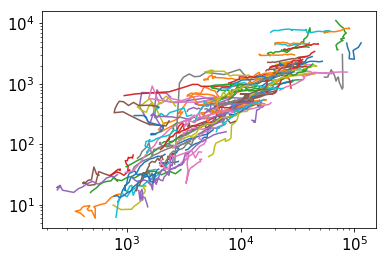

In [37]:
# plot the correlation between residential elc use and gdp for the whole world
for c in gdp_pp.index:
    try:
        plt.loglog(gdp_pp.loc[c,:],res_elc_pp.loc[c,:])
    except(KeyError):
        pass

In [38]:
# import region names
regions = pd.read_excel(data_dir+'country_mapping.xlsx',sheet_name='regions')
regions.head()

,REG-TIAM_15,REG-TIAM_36 Region Name,COUNTRY_ISO,Country Name,COUNTRY_UNPD,COUNTRY,REG-TIAM_all,Color code,Group,Unnamed: 9,Country dict,Unnamed: 11,Region dict,Unnamed: 13,Unnamed: 14,"""COUNTRY_ISO"",""REG-TIAM_all"""
0,AFR,Western Africa,XXX,(blank),(blank),(blank),AWE,#B3CD1C,Africa,"'XXX': ['XXX','(blank)', '(blank)'],","'XXX': ['XXX','(BLANK)', '(BLANK)'],",NaN,"'XXX': 'AWE',",NaN,NaN,"""XXX"",""AWE"""
1,AFR,Algeria,DZA,Algeria,Algeria,Algeria,DZA,#F6EF80,Africa,"'DZA': ['DZA','Algeria', 'Algeria'],","'DZA': ['DZA','ALGERIA', 'ALGERIA'],",NaN,"'DZA': 'DZA',",NaN,NaN,"""DZA"",""DZA"""
2,AFR,Angola,AGO,Angola,Angola,Angola,AGO,#B693C4,Africa,"'AGO': ['AGO','Angola', 'Angola'],","'AGO': ['AGO','ANGOLA', 'ANGOLA'],",NaN,"'AGO': 'AGO',",NaN,NaN,"""AGO"",""AGO"""
3,AFR,Western Africa,BEN,Benin,Benin,Benin,AWE,#B3CD1C,Africa,"'BEN': ['BEN','Benin', 'Benin'],","'BEN': ['BEN','BENIN', 'BENIN'],",NaN,"'BEN': 'AWE',",NaN,NaN,"""BEN"",""AWE"""
4,AFR,Southern Africa,BWA,Botswana,Botswana,Botswana,ASO,#EA4F58,Africa,"'BWA': ['BWA','Botswana', 'Botswana'],","'BWA': ['BWA','BOTSWANA', 'BOTSWANA'],",NaN,"'BWA': 'ASO',",NaN,NaN,"""BWA"",""ASO"""


In [39]:
# select african countries
african_countries = regions[regions['REG-TIAM_15']=='AFR']['COUNTRY_ISO'].unique()
african_countries

array(['XXX', 'DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CMR', 'CPV',
       'CAF', 'TCD', 'COM', 'COG', 'CIV', 'COD', 'DJI', 'EGY', 'GNQ',
       'ERI', 'ETH', 'GAB', 'GMB', 'GHA', 'GIN', 'GNB', 'KEN', 'LSO',
       'LBR', 'LBY', 'MDG', 'MWI', 'MLI', 'MRT', 'MUS', 'MYT', 'MAR',
       'MOZ', 'NAM', 'NER', 'NGA', 'REU', 'RWA', 'SHN', 'STP', 'SEN',
       'SYC', 'SLE', 'SOM', 'ZAF', 'SSD', 'SDN', 'SWZ', 'TGO', 'TUN',
       'UGA', 'TZA', 'ESH', 'ZMB', 'ZWE'], dtype=object)

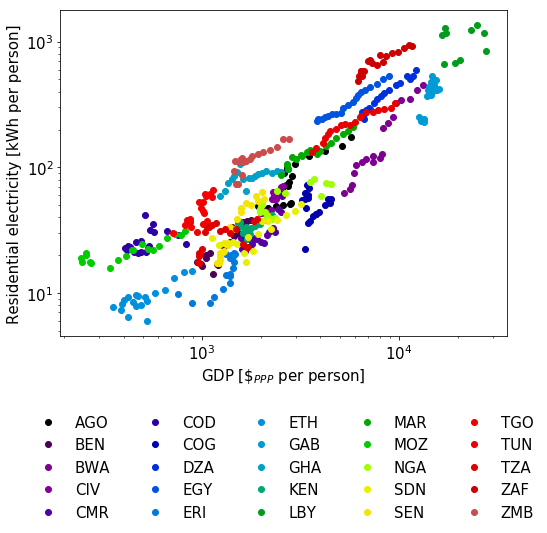

In [40]:
def c_position(c):
    l = [i for i,x in enumerate(sorted(african_countries)) if x == c]
    return (l[0])/len(african_countries)

cmap = plt.get_cmap('nipy_spectral')

# residential elc and gdp correlation for african countries
for c in gdp_pp.index:
    if c in african_countries and c not in ['ZWE']:
        try:
            plt.loglog(gdp_pp.loc[c,:],res_elc_pp.loc[c,:],'o', c=cmap(c_position(c)))
        except(KeyError):
            pass
#plt.title('Electricity use vs gdp in Africa (1990-2008)')
plt.ylabel('Residential electricity [kWh per person]')
plt.xlabel('GDP [\$$_{PPP}$ per person]')
plt.gcf().set_figwidth(8)
plt.gcf().set_figheight(6)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5, frameon=False)

plt.gcf().savefig('corr_eluse_gdp_afr.jpg',bbox_inches='tight', dpi = 250)

### Demand per person in 2005 

We use a linear regression of residential electricity use vs gdp for the missing countries.

In [41]:
# From the plot above: 
# We select just 2005 data for African countries
# and store them in a new DF
rg2005 = pd.DataFrame(res_elc_pp.loc[[c for c in african_countries if c in res_elc_pp.index],2005])
rg2005.columns = ['res_elc']
rg2005.loc[:,'gdp'] = gdp_pp.loc[:,'2005']
rg2005.head()

,res_elc,gdp
Country Code,,
DZA,532.70,10971.517420
AGO,122.60,3516.402658
BEN,36.87,1545.698265
BWA,345.20,10313.611186
CMR,30.50,2347.659063


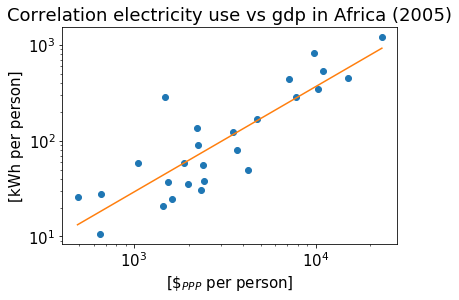

In [42]:
# We then make a fit a line through the data points
fit = np.polyfit(np.log(rg2005.gdp), np.log(rg2005.res_elc),1)

plt.loglog(rg2005.gdp, rg2005.res_elc, 'o') #, np.log(rg2005.gdp),np.poly1d(fit)(np.log(rg2005.gdp)))
plt.loglog(rg2005.sort_values(by='gdp').gdp,\
           np.exp(np.poly1d(fit)(np.log(rg2005.sort_values(by='gdp').gdp))),'-')

plt.title('Correlation electricity use vs gdp in Africa (2005)')
plt.ylabel('[kWh per person]')
plt.xlabel('[\$$_{PPP}$ per person]')

#plt.gcf().savefig('corr_elc_use_gdp_2005.jpg',bbox_inches='tight', dpi=150)

In [43]:
# let's bring back the country names
gdp = gdp_pp_his[gdp_pp_his['Country Name'].isin(pop.index)]
gdp2005 = gdp[['Country Code','Country Name','2005']].set_index('Country Code')
len(gdp2005)

48

In [44]:
# check for NaNs 
gdp2005[gdp2005['2005'].isnull()]

,Country Name,2005
Country Code,,
SOM,Somalia,NaN


In [45]:
# To fix somalia, let's use TIAM regional averages
gdp2005 = gdp2005.reset_index()\
                 .merge(regions[['Country Name','REG-TIAM_all']] ,how='left', on='Country Name')\
                 .set_index('Country Code')
len(gdp2005)

48

In [46]:
# iterate through nans and fill with regional averages
for i in gdp2005[gdp2005['2005'].isnull()].index:
    gdp2005.loc[i,'2005'] = gdp2005.groupby('REG-TIAM_all').mean().loc[gdp2005.loc[i,'REG-TIAM_all'],'2005']
len(gdp2005)

48

In [47]:
# add residential electricity 
gdp2005.loc[:,'res_elc'] = res_elc_pp.loc[:,2005]
len(gdp2005)

48

In [48]:
for i in gdp2005.index:
    if np.isnan(gdp2005.loc[i,'res_elc']):
        gdp2005.loc[i,'res_elc_fit'] = np.exp(np.poly1d(fit)(np.log(gdp2005.loc[i,'2005'])))
    else:
        gdp2005.loc[i,'res_elc_fit'] = gdp2005.loc[i,'res_elc']
len(gdp2005)

48

In [49]:
dem_pp_2005 = gdp2005[['Country Name','res_elc_fit']].set_index('Country Name')
dem_pp_2005.columns = ['2005']
#dem_pp_2005


### Demand per connected person
This should give an estimate of the tier. 

In [50]:
# import elc-access figures
el_acc = pd.read_excel("input_data\\el_acc.xlsx",sheet_name='Data',skiprows=3)

# create dem per connected person df:
dem_pcp_2005 = dem_pp_2005.reset_index()
dem_pcp_2005.columns = ['COUNTRY','dem_pp']
dem_pcp_2005 = dem_pcp_2005.merge(el_acc[['COUNTRY','2005']], on='COUNTRY')
dem_pcp_2005.columns = ['COUNTRY','dem_pp','el_acc']
dem_pcp_2005 = dem_pcp_2005.set_index('COUNTRY')

dem_pcp_2005.loc[:,'2005'] = 100 * dem_pcp_2005.loc[:,'dem_pp'] / dem_pcp_2005.loc[:,'el_acc'] # demand PCP in kWh
dem_pcp_2005 = dem_pcp_2005.drop(['dem_pp','el_acc'],axis=1)
#dem_pcp_2005

In [51]:
tier_2005 = dem_pcp_2005 / 365.
tier_2005.columns = ['daily_kWh']
def get_tier(x):
    """get the tier from daily el cons"""
    if x < 0.012:
        r = 0
    elif x >= 0.012 and x < 0.2: 
        r = 1
    elif x >= 0.2 and x < 1.0: 
        r = 2
    elif x >= 1.0 and x < 3.4: 
        r = 3
    elif x >= 3.4 and x < 8.2: 
        r = 4
    elif x >= 8.2: 
        r = 5
    else:
        r = np.nan
    return r
        
tier_2005.loc[:,'tier'] = tier_2005.loc[:,'daily_kWh'].apply(get_tier)
#tier_2005

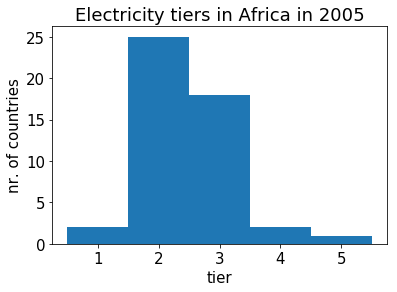

In [52]:
ax = tier_2005.groupby('tier').count().plot(kind='bar', rot=0, width=1, legend=False)
ax.set_ylabel('nr. of countries')
ax.set_title('Electricity tiers in Africa in 2005')
ax.get_figure().savefig('elc_tiers_2005.jpg', dpi=150)

### Demand projection

In [53]:
# We need GDP growth factors and % of pop with electricity access
gc = pd.read_excel(data_dir+"\\gdp_coeff.xlsx", sheet_name="Data").set_index('REG-TIAM_all')

# turn them into multipliers by adding1 and taking the 5th power
gc = (gc+1)**5 

# normalize
# take the cumulative products 
# (so that later we only need to multiply the 2010 value)
gc = gc.cumprod(axis=1)

gc = gc.reset_index()

# let's save the gcs per region in a separate DF that we will use later for the final TIAM input projections
gc_reg = gc[['REG-TIAM_all','2010','2020','2030','2040','2050','2060','2070','2080','2090','2100']]

# Let's now redifine gc for the first half of the century
gc = gc.merge(regions,on='REG-TIAM_all',how='left')
gc = gc[['COUNTRY','2010','2020','2030','2040','2050']]
gc = gc[gc.COUNTRY.isin(pop.index)].set_index('COUNTRY')
len(gc)
gc

,2010,2020,2030,2040,2050
COUNTRY,,,,,
Morocco,1.617690,2.516439,4.050420,6.320332,9.199180
Algeria,1.476789,2.253944,3.627912,5.661046,8.239595
Tunisia,1.540060,2.233846,3.595562,5.610566,8.166123
Libya,1.556926,0.871331,1.362847,2.046630,2.886920
Egypt,1.604984,2.314140,3.724803,5.812235,8.459649
Benin,1.487002,3.012152,5.653002,9.519631,15.469556
Burkina Faso,1.487002,3.012152,5.653002,9.519631,15.469556
Ivory Coast,1.487002,3.012152,5.653002,9.519631,15.469556
Gambia,1.487002,3.012152,5.653002,9.519631,15.469556


In [54]:
# Dataframe with pop in 2005 and correct country names

fi = pop_data['Indicator Name']=='Population, total'
pop_2005 = pop_data[fi][['Country Code','2005']]

fc = pop_2005['Country Code'].isin(gdp2005.index)
pop_2005 = pop_2005[fc].merge(gdp2005.reset_index()[['Country Code','Country Name']], on='Country Code')
pop_2005 = pop_2005[['Country Name','2005']]
pop_2005.columns = ['COUNTRY','2005']

pop_2005 = pop_2005.set_index('COUNTRY')
#pop_2005.head()

# Merge into pop df
pop.loc[:,'2005'] = pop_2005.loc[:,'2005']
#pop

In [55]:
def last_year_no_off(c):
    """
    For country c, returns the last year in which 
    the offgrid population projection was zero
    """
    df = off_pop.loc[c,:]
    return max(df[df.values==0].index)

#for c in off_pop.index:
#    print( c, last_year_no_off(c))

In [56]:
# total demand: 
tot_dem = on_pop.drop(on_pop.columns, axis=1) # initiate DF
tot_dem.loc[:,'2005'] = pop.loc[:,'2005'] * dem_pp_2005.loc[:,'2005'] * 3.6e-9  # total PJ
tot_dem.loc[:,'2010'] = pop.loc[:,'2010'] * dem_pp_2005.loc[:,'2005'] * 3.6e-9  # total PJ
#tot_dem.loc[:,'2010'] = on_pop.loc[:,'2010'] * dem_pcp_2005.loc[:,'2005'] * 3.6e-9  # total PJ

#on_dem

In [57]:
# make an overview of 2005 REA per TIAM-ECN region to compare with existing values in the DB
dem2005 = tot_dem.reset_index()
dem2005 = dem2005.merge(regions[['COUNTRY','REG-TIAM_all']] ,how='left', on='COUNTRY')
dem2005.groupby('REG-TIAM_all').sum().to_clipboard()
#dem2005 
# There are some large differences (up to 50-60%), but we still keep these results as leading

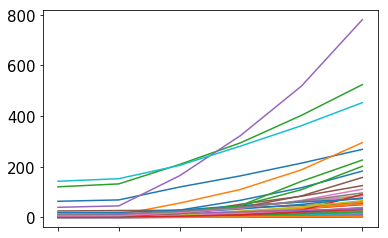

In [58]:
# total demand
DFp = 1.0  # main driver is population --> exponent > 1
DFg = 0.4  # secondary driver is GDP --> same exponent as in WTP projection
years_tot = ['2020','2030','2040','2050']
for y in years_tot: 
    tot_dem.loc[:,y] = tot_dem.loc[:,str(int(y)-10)] * (\
                       (on_pop.loc[:,y] + off_pop.loc[:,y] + overlap_pop.loc[:,y]) /\
                       (on_pop.loc[:,str(int(y)-10)] + off_pop.loc[:,str(int(y)-10)] + overlap_pop.loc[:,str(int(y)-10)])\
                                                     ) ** DFp\
                                                   * (gc.loc[:,y] / gc.loc[:,str(int(y)-10)]) ** DFg
tot_dem.transpose().plot(legend=False)

In [59]:
on_dem = tot_dem * on_pop / (on_pop + off_pop + overlap_pop)
off_dem = tot_dem * off_pop / (on_pop + off_pop + overlap_pop)
overlap_dem = tot_dem * overlap_pop / (on_pop + off_pop + overlap_pop)

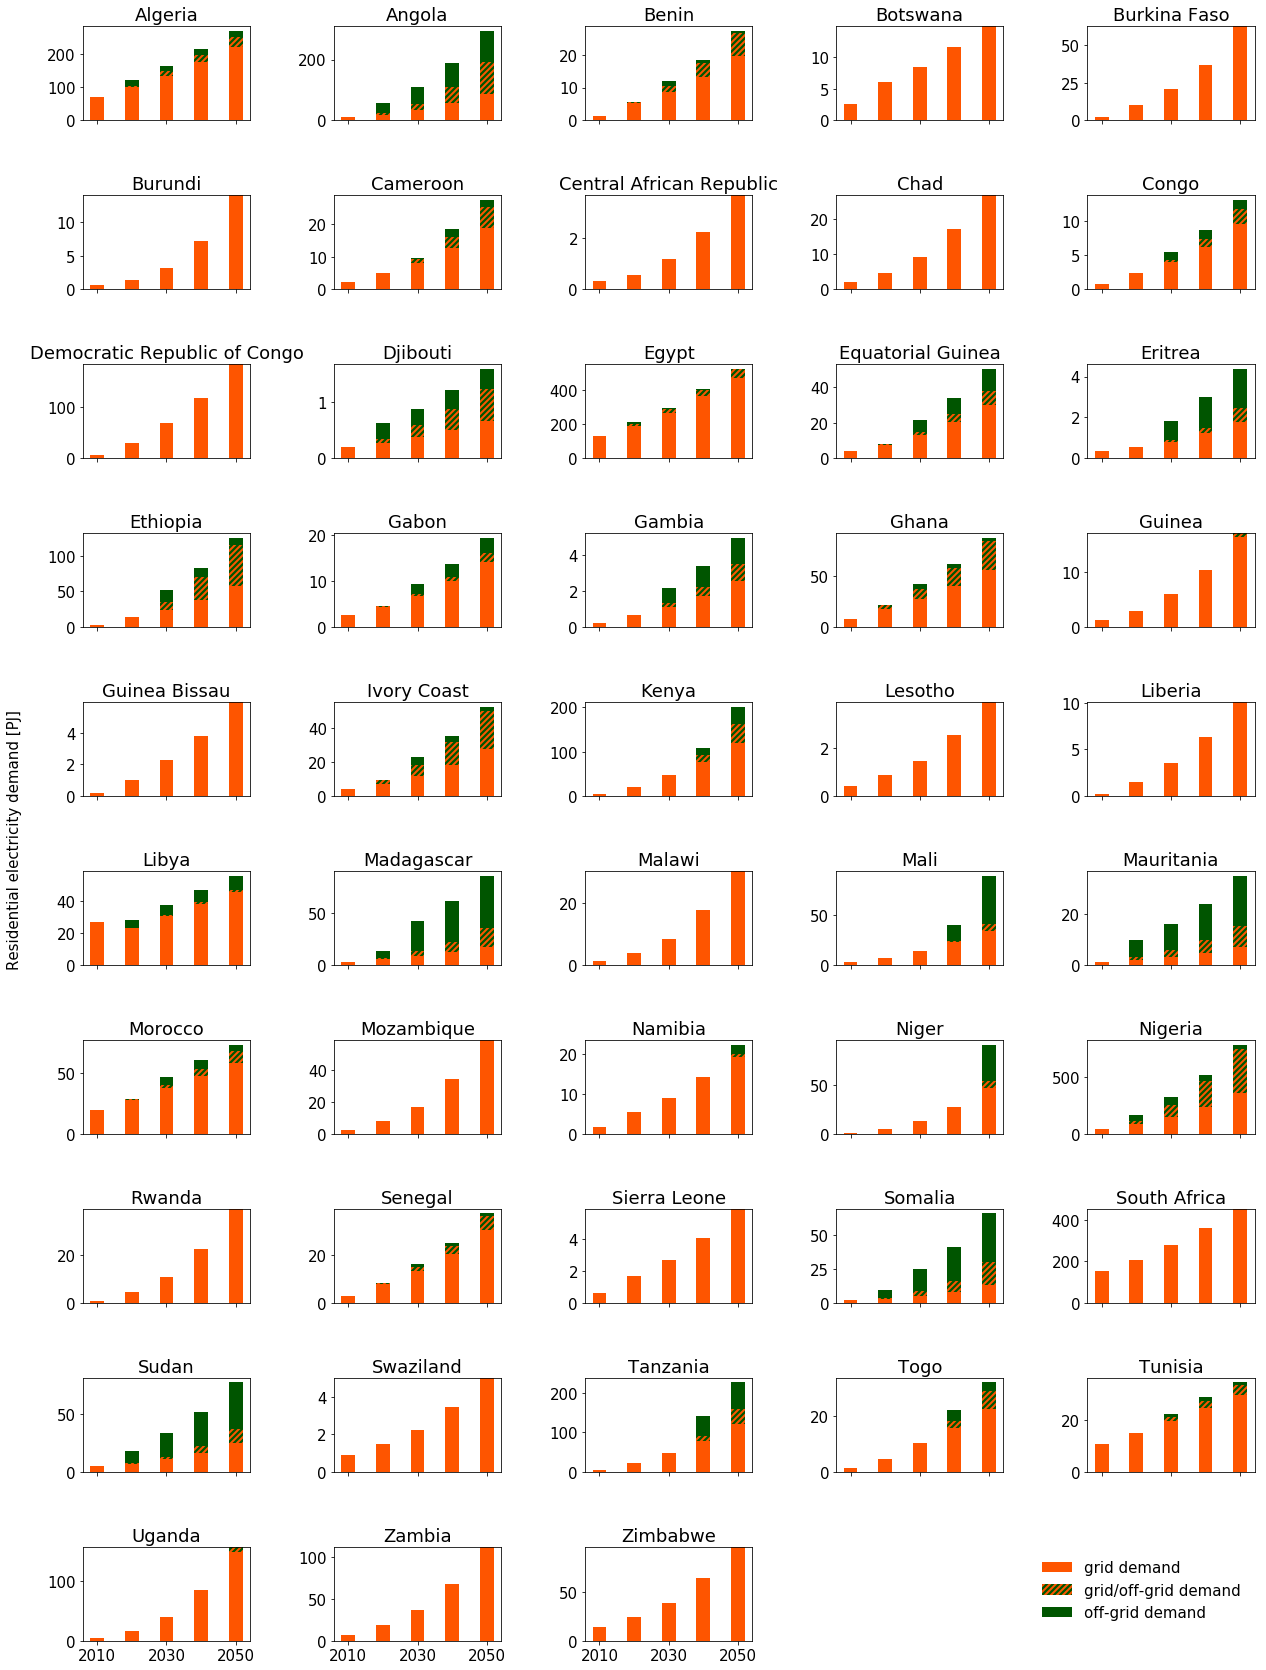

In [60]:
# Make a matrix of plots
rows = 10
cols = 5
fig, ax = plt.subplots(rows, cols, sharex='col') #, sharey='row')
fig.set_size_inches(21,29.7)
fig.subplots_adjust(hspace=0.8, wspace=0.5)

import matplotlib as mpl
bar_w = 4
orange = (254/255.,85/255.,0)
green = (0,85/255.,0)
mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = orange
mpl.rcParams['font.size'] = 15
for i in range(rows):
    for j in range(cols):
        idx = cols*i + j
        if idx < len(tot_dem):
            on_line = ax[i,j].bar(on_dem.columns.astype(float),\
                                  on_dem.iloc[idx,:],\
                                  bar_w,color=orange)
            
            overlap_line = ax[i,j].bar(on_dem.columns.astype(float),\
                                       overlap_dem.iloc[idx,:],\
                                       bar_w, color=green,hatch='////',\
                                       bottom = (on_dem.iloc[idx,:]))
            
            off_line = ax[i,j].bar(on_dem.columns.astype(float),\
                                   off_dem.iloc[idx,:],\
                                   bar_w, color=green,\
                                   bottom = (on_dem.iloc[idx,:] + overlap_dem.iloc[idx,:]))
            
            #pop_line, = ax[i,j].plot(pop_mil.iloc[idx,:].transpose(),':',color='black')
            
            
            ax[i,j].set_title(on_pop_mil.index[idx])
            ax[i,j].set_xticks([2010,2030,2050])
        elif idx == len(on_pop_mil):
            ax[i,j].axis('off')
            plt.legend([on_line,overlap_line,off_line], #,pop_line],
                       ['grid demand','grid/off-grid demand','off-grid demand'],
                       frameon = False)
        else:
            ax[i,j].axis('off')
            
# overall axes titles as text objects
fig.text(0.08, 0.5, 'Residential electricity demand [PJ]', ha='center', va='center', rotation='vertical')

# save
fig.savefig('demand.jpg',dpi=350)

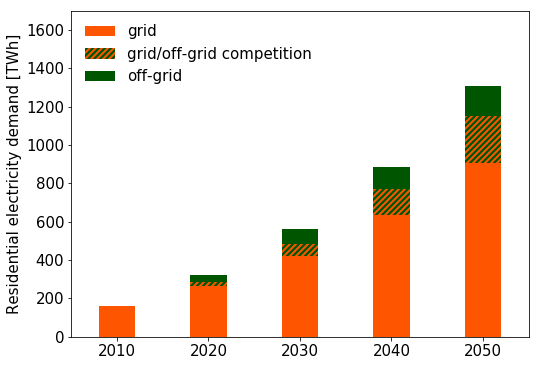

In [62]:
# And for the whole of Africa
cfac = {'EJ':1000.,'TWh':3.6}
units = 'TWh'
fig, ax = plt.subplots()
fig.set_size_inches(8.2,6)
on_line = ax.bar(on_dem.columns.astype(float),\
                 on_dem.sum()/cfac[units],\
                 bar_w,color=orange)
            
overlap_line = ax.bar(on_dem.columns.astype(float),\
                      overlap_dem.sum()/cfac[units],\
                      bar_w, color=green,hatch='////',\
                      bottom = (on_dem.sum())/cfac[units])
            
off_line = ax.bar(on_dem.columns.astype(float),\
                  off_dem.sum()/cfac[units],\
                  bar_w, color=green,\
                  bottom = (on_dem.sum()+overlap_dem.sum())/cfac[units])
            
#pop_line, = ax.plot(pop_mil.sum().transpose(),':',color='black')
            

#ax.set_title("Africa")
#ax.set_xticks([2010,2030,2050])
plt.legend([on_line,overlap_line,off_line], #,pop_line],
           ['grid','grid/off-grid competition','off-grid'], 
           frameon = False)
 
# overall title and y-axis label
#fig.suptitle('Residential electricity demand in Africa')            
ax.set_ylabel('Residential electricity demand [%s]'%units)
ax.set_xlim(2005, 2055)
ax.set_ylim(0, 1700)

# save
fig.savefig('demand_afr.jpg',dpi=250)

In [84]:
# create demand tables for exporting:
# off and overlap_dem: put 2005 to 0
off_exp = off_dem.fillna(0)
overlap_exp = overlap_dem.fillna(0)
# on_dem: put 2005 to dem2005
dem2005 = dem2005.set_index('COUNTRY')
on_exp = dem2005[['2005']]
for y in ['2010','2020','2030','2040','2050']:
    on_exp.loc[:,y] = on_dem.loc[:,y]
on_exp.head()

C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\CepPy3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\dallalongaf\AppData\Local\Enthought\Canopy\edm\envs\CepPy3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,2005,2010,2020,2030,2040,2050
COUNTRY,,,,,,
Algeria,63.837901,69.263515,98.432095,134.164686,174.835676,219.136151
Angola,8.629710,10.314200,18.130487,32.551160,55.335916,86.904345
Benin,1.059497,1.221036,5.195415,8.615608,13.319414,19.733534
Botswana,2.306304,2.503914,6.049724,8.401099,11.520726,14.877335
Burkina Faso,1.557527,1.810883,9.773363,20.832698,36.887268,62.511155


In [85]:
# group by tiam region 
def group_by_reg(df):
    """
    Group data by summing over TIAM regions.
    Returns grouped DF.
    """
    ret = df.reset_index()\
            .merge(regions[['COUNTRY','REG-TIAM_all']],on='COUNTRY')\
            .groupby('REG-TIAM_all').sum()#.transpose()
    return ret

on_exp_reg = group_by_reg(on_exp)
off_exp_reg = group_by_reg(off_exp)
overlap_exp_reg = group_by_reg(overlap_exp)

# GDP growth factors per TIAM region
gc_reg = gc_reg.set_index('REG-TIAM_all')


In [86]:
# add GDP-driven projection to 2100
for y in ['2060','2070','2080','2090','2100']:
    on_exp_reg.loc[:,y] = on_exp_reg.loc[:,str(int(y)-10)] * (gc_reg.loc[:,y] / gc_reg.loc[:,str(int(y)-10)]) **DFg
    off_exp_reg.loc[:,y] = off_exp_reg.loc[:,str(int(y)-10)] * (gc_reg.loc[:,y] / gc_reg.loc[:,str(int(y)-10)]) **DFg
    overlap_exp_reg.loc[:,y] = overlap_exp_reg.loc[:,str(int(y)-10)] * (gc_reg.loc[:,y] / gc_reg.loc[:,str(int(y)-10)]) **DFg


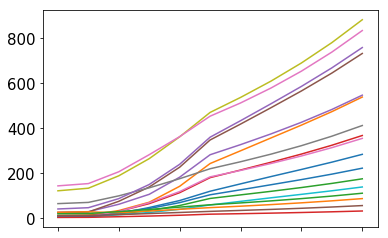

In [87]:
on_exp_reg.transpose().plot(legend=False)

In [88]:
# export to excel
writer = pd.ExcelWriter('demand.xlsx')
on_exp_reg.to_excel(writer,'REA')
(off_exp_reg + overlap_exp_reg).to_excel(writer,'RER')
overlap_exp_reg.to_excel(writer,'overlap')
writer.save()
writer.close()

### Electricity tier projection

In [89]:
# total demand in PJ
tot_dem_kwh = tot_dem / 3.6e-9

# total demand per connected person per day
tot_dem_daily_kwh_pcp = tot_dem_kwh / (on_pop + off_pop + overlap_pop) / 365.
tot_dem_daily_kwh_pcp = tot_dem_daily_kwh_pcp.drop('2005',axis=1)

# tier - initialize df
tier_prj = tier_2005[['tier']]
tier_prj.columns = ['2005']

# tier - apply get_tier function
for y in tot_dem_daily_kwh_pcp.columns:
    tier_prj.loc[:,y] = tot_dem_daily_kwh_pcp.loc[:,y].apply(get_tier)

# count nr. of countries in each tier and save in new df tier_frq
tier_frq = tier_prj.groupby('2005').count()[['2010']]
tier_frq.index.name = 'tier'
tier_frq.columns = [['2005']]
for y in tier_prj.columns[1:]:
    tier_frq.loc[:,y] = tier_prj.groupby(y).count().iloc[:,1]
tier_frq = tier_frq.fillna(0)
tier_frq

,2005,2010,2020,2030,2040,2050
tier,,,,,,
1,2,3.0,1.0,0.0,0.0,0.0
2,25,28.0,27.0,23.0,12.0,11.0
3,18,15.0,18.0,21.0,29.0,27.0
4,2,2.0,2.0,3.0,6.0,9.0
5,1,0.0,0.0,1.0,1.0,1.0


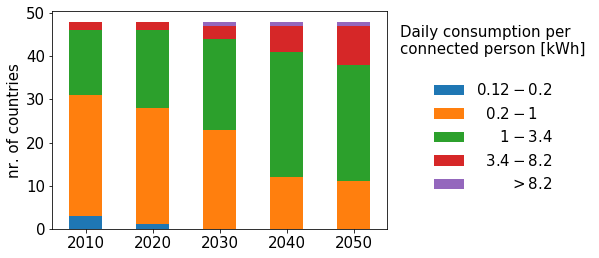

In [97]:
# plot
ax = tier_frq.transpose().plot(kind='bar', stacked=True, rot=0)
ax.set_xticklabels([c[0] for c in tier_frq.columns])
ax.set_ylabel('nr. of countries')
#ax.set_title('Tier distribution projection')
ax.set_xlim(0.5,5.5)
lgd = plt.legend(labels = ['$0.12 - 0.2$','  $0.2 - 1$', '     $1 - 3.4$', '  $3.4 - 8.2$', '       $> 8.2$'],\
                 title = 'Daily consumption per\nconnected person [kWh]\n', loc='upper left', bbox_to_anchor=(1, 1),\
                 frameon = False)
#lgd._legend_box.align = "left"

#lgd.get_title().set_ha('center')
#lgd.get_title().set_position((170,0))


ax.get_figure().savefig('tiers_prj.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=250)

In [92]:
plt.legend?

In [69]:
(off_exp+overlap_exp).to_excel("off-grid_demand.xlsx")

In [70]:
on_dem.sum() + overlap_dem.sum() + off_dem.sum()

2005       0.000000
2010     571.708452
2020    1161.141867
2030    2014.056008
2040    3179.741653
2050    4713.203413
dtype: float64